In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import colorednoise as cn


# Class to generate and analyze colored noise
class GenerateNoise:
    def __init__(self, sample_rate, t_max, relative_PSD_strength, num_realizations, ifwhite=True, fmin=0.):
        """
        Initialize the noise generator with parameters.
        
        Parameters:
        -----------
        sample_rate : float
            Sampling rate in 1/ns
        t_max : int
            Maximum time in number of samples
        relative_PSD_strength : float
            Target PSD strength at f→0
        num_realizations : int
            Number of noise realizations to generate
        ifwhite : bool, optional
            If True, generates white noise, otherwise 1/f noise. Default is True.
        fmin : float, optional
            Minimum frequency, default is 0
        """
        self.sample_rate = sample_rate
        self.t_max = t_max
        self.dt = 1/sample_rate
        self.relative_PSD_strength = relative_PSD_strength
        self.num_realizations = num_realizations
        self.ifwhite = ifwhite
        self.fmin = fmin
        self.N = self.t_max * self.sample_rate
        self.noise_type = "White Noise" if self.ifwhite else "1/f Noise"
        
    def generate_colored_noise(self):
        """
        Generate realizations of 1/f^alpha noise based on initialized parameters.
        Returns array of shape (num_realizations, N).
        """
        import joblib
        
        alpha = 0 if self.ifwhite else 1
        
        # Define a function to generate a single noise realization
        def generate_single_noise():
            return cn.powerlaw_psd_gaussian(alpha, self.N, fmin=self.fmin) * np.sqrt(self.relative_PSD_strength * self.sample_rate)
        
        # Use joblib to parallelize the generation
        trajectories = joblib.Parallel(n_jobs=-1)(
            joblib.delayed(generate_single_noise)() 
            for _ in range(self.num_realizations)
        )
        
        return np.array(trajectories)
        
    def analyze_noise_psd(self, trajectories):
        """
        Analyze noise trajectories: compute PSD, plot it, and perform sanity checks.
        
        Parameters:
        -----------
        trajectories : ndarray
            Noise trajectories of shape (num_realizations, num_samples)
        
        Returns:
        --------
        dict
            Dictionary containing computed values (freqs, avg_psd, median_ratio, std_ratio)
        """
        import joblib
        
        # Compute frequencies for FFT
        freqs = np.fft.rfftfreq(self.N, d=self.dt)*2*np.pi
        self.freqs = freqs

        # Define a function to compute PSD for a single trajectory
        def compute_psd(trajectory):
            return np.abs(np.fft.rfft(trajectory))**2 / self.sample_rate**2 / self.t_max
        
        # Use joblib to parallelize PSD computation
        psds = joblib.Parallel(n_jobs=-1)(
            joblib.delayed(compute_psd)(trajectory) 
            for trajectory in trajectories
        )
        psds = np.array(psds)
        
        # Average PSD
        avg_psd = psds.mean(axis=0)
        self.avg_psd = avg_psd
        # Plot average PSD
        plt.figure(figsize=(7,5))
        plt.loglog(freqs, avg_psd, 'b', label='Measured PSD')
        plt.xlabel('Frequency/2pi [GHz]')
        plt.ylabel('PSD [units^1/Hz]')
        plt.title(f'Average PSD of {self.noise_type}')
        plt.grid(True, linestyle='--', alpha=0.5)
        
        # Sanity checks
        # 1) Median raw periodogram / (S0 * t_max)
        median_ratio = np.median(avg_psd) / (self.relative_PSD_strength )
        # 2) Std dev of integrated phase / sqrt(S0 * t_max)
        phi = np.cumsum(trajectories * self.dt, axis=1)
        std_ratio = np.std(phi[:, -1]) / np.sqrt(self.relative_PSD_strength * self.t_max)
        
        print(f'Sanity Checks ({self.noise_type.lower()}):')
        if self.noise_type.lower() == 'white noise':
            print(f"Median raw periodogram / (S0 ): {median_ratio:.6f}")
            print(f"Std dev of integrated phase / sqrt(S0 * t_max): {std_ratio:.6f}")
        else:
            # Fit the PSD in log10 scale to get the slope (should be close to -1 for 1/f noise)
            # Skip the first few points to avoid DC component
            mask_neg = freqs < 0  # Exclude zero frequency
            mask_pos = freqs > 0  # Positive frequencies
            
            # Process negative frequencies
            if np.any(mask_neg):
                log_freqs_neg = np.log10(np.abs(freqs[mask_neg]))
                log_psd_neg = np.log10(avg_psd[mask_neg])
                
                # Linear regression for negative frequencies
                slope_neg, intercept_neg, r_value_neg, p_value_neg, std_err_neg = stats.linregress(log_freqs_neg, log_psd_neg)
                
                # Calculate noise amplitude for negative frequencies
                noise_amplitude_neg = 10**intercept_neg
                
                # Plot the fitting curve for negative frequencies
                fit_psd_neg = 10**(slope_neg * np.log10(np.abs(freqs[mask_neg])) + intercept_neg)
                plt.loglog(np.abs(freqs[mask_neg]), fit_psd_neg, 'r--', label=f'Fit (f<0): 1/f^{-slope_neg:.2f}')
            
            # Process positive frequencies
            if np.any(mask_pos):
                log_freqs_pos = np.log10(freqs[mask_pos])
                log_psd_pos = np.log10(avg_psd[mask_pos])
                
                # Linear regression for positive frequencies
                slope_pos, intercept_pos, r_value_pos, p_value_pos, std_err_pos = stats.linregress(log_freqs_pos, log_psd_pos)
                
                # Calculate noise amplitude for positive frequencies
                noise_amplitude_pos = 10**intercept_pos
                
                # Plot the fitting curve for positive frequencies
                fit_psd_pos = 10**(slope_pos * np.log10(freqs[mask_pos]) + intercept_pos)
                plt.loglog(freqs[mask_pos], fit_psd_pos, 'g--', label=f'Fit (f>0): 1/f^{-slope_pos:.2f}')
            
            plt.legend()
            
            # Use positive frequency fit for S0 calculation (more typical)
            if np.any(mask_pos):
                slope = slope_pos
                noise_amplitude = noise_amplitude_pos
                r_value = r_value_pos
            else:
                slope = slope_neg
                noise_amplitude = noise_amplitude_neg
                r_value = r_value_neg
                
            S0 = np.sqrt(noise_amplitude/(2*np.pi))
            print(f"PSD fit: power = {slope:.4f}, intercept = {intercept_pos if np.any(mask_pos) else intercept_neg:.4f}, R² = {r_value**2:.4f}, S0 = {S0:.6e}")
        
            
        # Add S0 to the plot title for clarity
        plt.title(f'Average PSD of {self.noise_type} ')
        plt.tight_layout()
        plt.show()
        # Return S0 value for 1/f noise
        if self.noise_type.lower() == 'white noise':
            return self.relative_PSD_strength
        else:
            return S0
            
        
    
    def run_analysis(self):
        """
        Generate and analyze noise trajectories with the initialized parameters.
        
        Returns:
        --------
        dict
            Dictionary containing analysis results
        """
        # Generate noise trajectories
        trajectories = self.generate_colored_noise()
        
        # Analyze the trajectories
        results = self.analyze_noise_psd(trajectories)
        
        return results
    

In [6]:
sample_rate = 1               # per ns
tnoise_max = int(1e5)             # number of samples
omega_ir = 1/tnoise_max*2*np.pi
S0 = 1e-2
relative_PSD_strength = S0**2
num_realizations = 1000
ifwhite = False               # True for white noise, False for 1/f noise
# Generate white noise (unit variance) trajectories
N = tnoise_max * sample_rate
gn = GenerateNoise(sample_rate, tnoise_max, relative_PSD_strength, num_realizations, ifwhite)

In [7]:
trajs = gn.generate_colored_noise()

Sanity Checks (1/f noise):
PSD fit: power = -1.0001, intercept = -4.5598, R² = 0.9990, S0 = 2.094051e-03


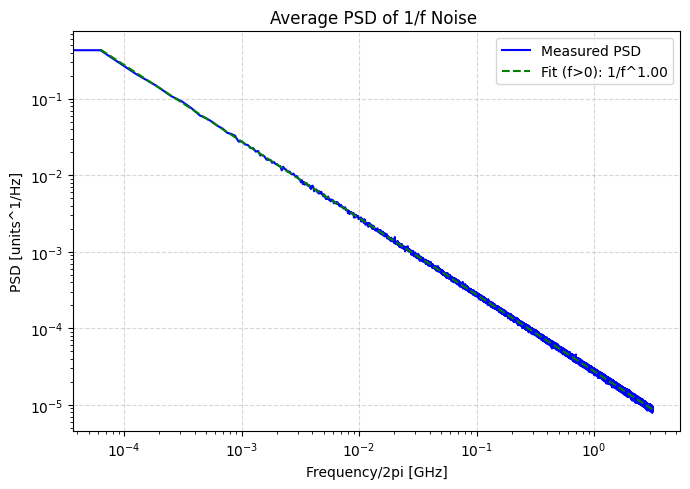

In [8]:
S0 = gn.analyze_noise_psd(trajs)

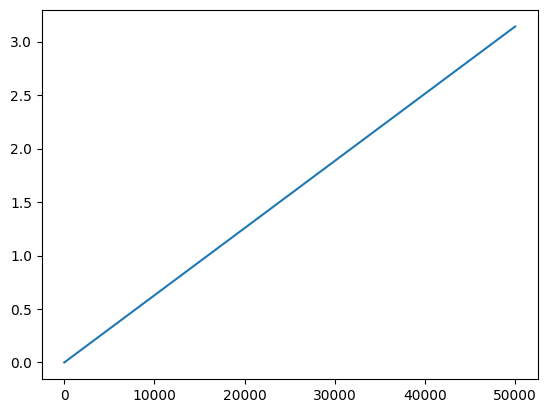

In [11]:
plt.plot(gn.freqs, )

In [54]:
# Perform quantum simulation with noise trajectories
from qutip import sesolve, basis, sigmaz, sigmax

# Initialize arrays to store results
all_expect_values = []
t_max = 300
N = t_max
time_points = np.linspace(0, t_max, N)  # Time points matching noise trajectory

# Initial state from file_context_0
initial_state = (basis(2, 0) + basis(2, 1)).unit()  # + state (1/sqrt(2)) * (|0> + |1>)
sigma_x = sigmax()
sigma_z = -sigmaz()

# Loop through each noise trajectory
for i in range(num_realizations):
    # Create time-dependent Hamiltonian with noise
    H = [[qt.Qobj([[0, 0], [0, 1]]), lambda t, args: trajs[i][int(t * sample_rate)] if t < t_max else 0]]
    
    # Solve the dynamics
    result = sesolve(H, initial_state, time_points, e_ops=[sigma_x])
    
    # Store the expectation values
    all_expect_values.append(result.expect[0])

# Convert to numpy array for easier analysis
all_expect_values = np.array(all_expect_values)


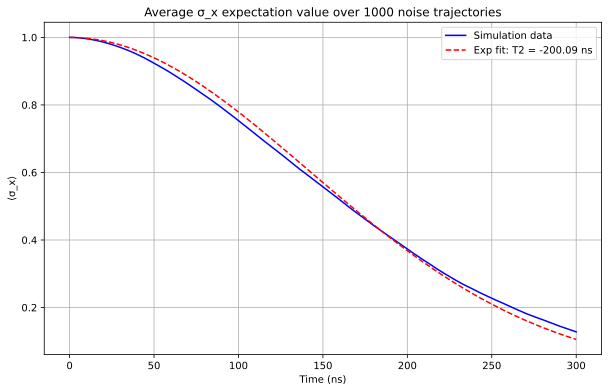

Fitted T2 time = -200.0904 ns


In [55]:
# Calculate the average over all trajectories
avg_sigmax = np.mean(all_expect_values, axis=0)

# Define exponential decay function for fitting
def exp_decay(t, T2):
    return np.exp(-t**2/ T2**2)  # No amplitude parameter

# Fit the data with exponential decay
from scipy.optimize import curve_fit
params, pcov = curve_fit(exp_decay, time_points, avg_sigmax, p0=[1000])
T2_fit = params[0]

# Plot the results with the fit
plt.figure(figsize=(10, 6))
plt.plot(time_points, avg_sigmax, 'b-', label='Simulation data')
plt.plot(time_points, exp_decay(time_points, T2_fit), 'r--', 
         label=f'Exp fit: T2 = {T2_fit:.2f} ns')
plt.xlabel('Time (ns)')
plt.ylabel('⟨σ_x⟩')
plt.title(f'Average σ_x expectation value over {num_realizations} noise trajectories')
plt.legend()
plt.grid(True)
plt.show()

# Print the fitted parameters
print(f"Fitted T2 time = {T2_fit:.4f} ns")


In [56]:
T2_fit

np.float64(-200.09037404203042)

In [59]:
# Theoretical prediction for T2 with 1/f noise
T2_theory = 1/(S0*np.sqrt(2)*np.sqrt(abs(np.log(omega_ir*t_max))))
print(f"Theoretical T2 prediction = {T2_theory:.4f} ns")

Theoretical T2 prediction = 169.4365 ns


In [60]:
from hamiltonian_generator import Hamiltonian
import qutip as qt


phi_ex = 0.2
Ej = 30.19 
Ec = 0.1
sc = Hamiltonian(phi_ex, Ej, Ec, [5,3])
H0 = qt.Qobj(sc.H)
H_control = qt.Qobj(sc.H_control)
A = 5e-3 * 2 * np.pi
optimal_omega = sc.optimal_omegad(A)[0]*2*np.pi

sc = Hamiltonian(phi_ex, Ej, Ec, [2,1])
H0 = qt.Qobj(sc.H)
H_control = qt.Qobj(sc.H_control)
# Make diagonal term subtract the first element
noise_matrix = sc.noise.copy()
first_element = noise_matrix[0, 0]
for i in range(noise_matrix.shape[0]):
    noise_matrix[i, i] -= first_element
noise = noise_matrix
noise = qt.Qobj(sc.noise)


In [61]:
noise_matrix = sc.noise.copy()
first_element = noise_matrix[0, 0]
for i in range(noise_matrix.shape[0]):
    noise_matrix[i, i] -= first_element
noise = qt.Qobj(noise_matrix)


In [62]:
_, state_and_sigmax, get_projector = sc.setup_floquet_system(A , optimal_omega)
U_init , _ = state_and_sigmax(0)
init_state = U_init[:,0]
init_state = qt.Qobj(init_state)

In [63]:
init_state

Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[0.97261966+0.j        ]
 [0.00562134+0.23233466j]]

In [64]:
H0

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-5.30936513e-03 -1.34800553e-20]
 [-1.34800553e-20  3.86933874e+01]]

In [65]:
# Perform quantum simulation with noise trajectories
from qutip import sesolve, basis, sigmaz, sigmax

# Initialize arrays to store results
all_expect_values = []
t_max = 300
N = t_max
time_points = np.linspace(0, t_max, N)  # Time points matching noise trajectory

# Initial state from file_context_0
# initial_state = (basis(2, 0) + basis(2, 1)).unit()  # + state (1/sqrt(2)) * (|0> + |1>)
initial_state = init_state
sigma_x = sigmax()
sigma_z = -sigmaz()

# Loop through each noise trajectory
for i in range(num_realizations):
    # Create time-dependent Hamiltonian with noise
    H = [H0, [H_control, lambda t, args: A * np.cos(optimal_omega * t)], [qt.Qobj([[0, 0], [0, 1]]), lambda t, args: trajs[i][int(t * sample_rate)] if t < t_max else 0]]
    
    # Solve the dynamics
    result = sesolve(H, initial_state, time_points)
    # Calculate projector averages for each time point
    avg_values = np.zeros((2, len(time_points)))
    for j, t in enumerate(time_points):
        # Get the state at time t
        state_t = result.states[j]
        
        # Get the projector at time t
        U, _ = state_and_sigmax(t)
        projectors = get_projector(U)
        
        # Calculate expectation values for both projectors
        avg_values[0, j] = qt.expect(projectors[0], state_t)
        avg_values[1, j] = qt.expect(projectors[1], state_t)
    
    # Store the expectation values for both projectors
    all_expect_values.append(avg_values)

# Convert to numpy array for easier analysis
all_expect_values = np.array(all_expect_values)


In [66]:
avg_expect_values = np.mean(all_expect_values, axis=0)

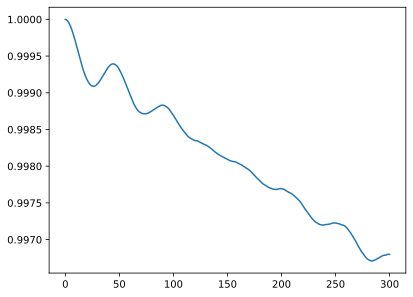

In [67]:
plt.plot(time_points, avg_expect_values[0, :])

In [45]:
# Calculate the average over all trajectories
avg_sigmax = np.mean(all_expect_values, axis=0)

# Define exponential decay function for fitting
def exp_decay_with_oscillation(t, T2, w):
    return np.exp(-t**2 / T2**2) * np.cos(w * t)

# Define envelope function (without oscillation)
def exp_decay_envelope(t, T2):
    return np.exp(-t**2 / T2**2)

# Fit the data with exponential decay
from scipy.optimize import curve_fit
# Initial guess for parameters: T2, w
initial_guess = [1000, 38.693]  # Using w value from context
params, pcov = curve_fit(exp_decay_with_oscillation, time_points, avg_sigmax, p0=initial_guess)
T2_fit, w_fit = params

# Plot the results with just the envelope
plt.figure(figsize=(10, 6))
plt.plot(time_points, avg_sigmax, 'b-', label='Simulation data')
plt.plot(time_points, exp_decay_envelope(time_points, T2_fit), 'r--', 
         label=f'Envelope: T2 = {T2_fit:.2f} ns')
plt.xlabel('Time (ns)')
plt.ylabel('⟨σ_x⟩')
plt.title(f'Average σ_x expectation value over {num_realizations} noise trajectories')
plt.legend()
plt.grid(True)
plt.show()

# Print the fitted parameters
print(f"Fitted T2 time = {T2_fit:.4f} ns")


ValueError: object too deep for desired array

error: Result from function call is not a proper array of floats.